In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg-iaf', '025deg-ryf', '01deg']


In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 35167:127.0.0.1:35167 vdi-n22.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:40652 Dashboard: http://127.0.0.1:35167/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [8]:
def find_temp(ekey, n_files):
    
    expt = exptdata.exptdict[ekey]['expt']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                          chunks={'st_ocean': None}, n=-n_files,
                          time_units = time_units, offset=offset)
    upper_temp_eq = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=slice(-217,-95)).mean('time').load() - 273.15
    upper_temp_140w = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=slice(-8,10))\
                        .sel(xt_ocean=-140.,method='nearest').mean('time').load() - 273.15

    return upper_temp_eq, upper_temp_140w


def find_u(ekey, n_files):
    
    expt = exptdata.exptdict[ekey]['expt']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    u = cc.get_nc_variable(expt, 'ocean.nc', 'u',
                          chunks={'st_ocean': None}, n=-n_files,
                          time_units = time_units, offset=offset)
    upper_u_eq = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=slice(-217,-95)).mean('time').load()*100
    upper_u_140w = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=slice(-8,10))\
                        .sel(xu_ocean=-140.,method='nearest').mean('time').load()*100

    return upper_u_eq, upper_u_140w


/home/157/amh157/cosima-cookbook/cosima_cookbook/netcdf_index.py:396: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)


/home/157/amh157/cosima-cookbook/cosima_cookbook/netcdf_index.py:396: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)


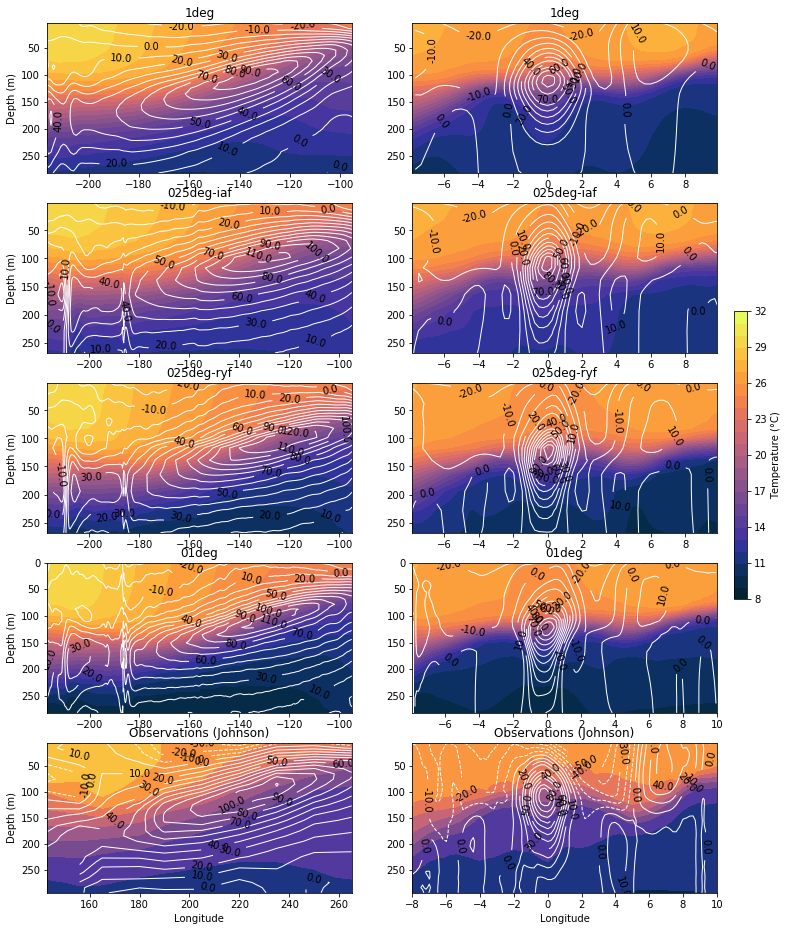

In [15]:
clevels = np.arange(-50,130,10)
n_files = [2, 10, 10, 48]  ## does the last n_files
plt.figure(figsize=(12,16))

for i, ekey in enumerate(exptdata.exptdict.keys()):
    upper_temp_eq, upper_temp_140w = find_temp(ekey,n_files[i])
    upper_u_eq, upper_u_140w = find_u(ekey,n_files[i])

    plt.subplot(5,2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   vmin=8., vmax=32.,levels=25,
                                   add_colorbar=False)
    p2=upper_u_eq.plot.contour(colors='w',levels=clevels,linewidths=1)
    plt.clabel(p2, fmt='%2.1f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(ekey)
    

    plt.subplot(5,2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     vmin=8., vmax=32.,levels=25,
                                     add_colorbar=False)
    p4=upper_u_140w.plot.contour(colors='w',levels=clevels,linewidths=1)
    plt.clabel(p4, fmt='%2.1f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(ekey)

    

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Temperature (°C)')

obs_file = xr.open_dataset('/g/data1/v45/fw4078/obs-data/meanfit_m.cdf')
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(XLON=220, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

obs_u = obs_file['UM']
obs_u_140w = obs_u.sel(ZDEP1_50=slice(0,300)).sel(XLON=220., method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
obs_u_eq = obs_u.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
lon_u_obs = obs_u_eq.XLON

plt.subplot(5,2,9)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, vmin=8., vmax=32.)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevels)
plt.clabel(p2, fmt='%2.1f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('Observations (Johnson)')


plt.subplot(5,2,10)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, vmin=8., vmax=32.)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevels)
plt.clabel(p2, fmt='%2.1f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Observations (Johnson)')

savefigure('equatorial_pacific')